In [1]:
!pip install loguru

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Populating the Database

In [2]:
# Ensure that utils.py is in the same directory as this notebook
from utils import *
import pandas as pd
from datetime import datetime

In [3]:
FILENAME = "/content/clean_data.csv"
NUM_CORES = 7   # Uncomment if needed
DB_NAME = "data_test.db"

In [4]:
def execute_sql_statement(sql_statement, conn):
    """
    Function to execute a valid SQL query on a connection object and fetch the result set.
    Args:
        sql_statement: A valid sql statement.
        conn: An SQLite3 connection object
    Returns:
        rows: The rows returned when the SQL query is executed.
    """
    cur = conn.cursor()
    cur.execute(sql_statement)
    rows = cur.fetchall()
    return rows


In [5]:
def create_id_dictionary(db_name,table):
    """
    Fetch ID-Value pairs from a user-specified table.
    Args:
        db_name: The SQLite3 database that the table belongs to.
        table: The table to containing the ID-Value pairs.
    Returns:
        id_dict: Dictionary which maps the values to their respective IDs from the table.
    """

    select_query = f"select * from {table};"
    norm_conn = create_sqlite3_connection(db_name)   # create_sqlite3_connection has been defined in utils.py
    with norm_conn as conn:
        rows = execute_sql_statement(select_query,conn)
    
    id_dict = {row[1]:row[0] for row in rows}
    return id_dict

In [44]:
def create_file_chunks(filename,chunksize):
    """
    Helper function to create chunks of .csv files from a user-defined csv file. The original file is chunked on the number fo rows.
    Args:
        filename (str): Filename of the original .csv file which is to be divided into chunks.
        chunksize (int): Number of rows in each chunk.

    Returns:
        filenames (list): List of filepaths corresponding to each file chunk.
    """

    filenames = []

    for i,chunk in enumerate(pd.read_csv(filename,chunksize=chunksize)):
        filename = f'chunk{i}.csv'
        chunk.to_csv(filename, index=False)
        logger.debug(f"Finished writing chunk at {filename}")
        filenames.append(filename)
    return filenames


In [6]:
def insert_into_county(csv_filename,db_name,col_table_alias=dict()):
    """Helper function to move data from a specified .csv file to county table in a user-specified db.

    Args:
        csv_filename (str): The path of the .csv file containing the data.
        db_name (str): The name of the db containing the table to which data is to be moved.
        cols_table_alias (dict): Dictionary which maps the name of the columns of the .csv corresponding to the columns in the .csv which are to be moved. Defaults to empty list (Denotes all columns are to be inserted into).
    """
    clean_df = pd.read_csv(csv_filename)
    state_dict = create_id_dictionary(db_name,table="state")
    values_to_insert = []
    cols_subset = ['county','state']
    transform_stateid = lambda x: [x[0],state_dict[x[1]]]

    for _,line in clean_df.iterrows():
        vals = [line[col] for col in cols_subset]
        vals = transform_stateid(vals)

        if tuple(vals) not in values_to_insert:
            values_to_insert.append(tuple(vals))
        else:
            continue

    try:
        conn_obj = create_sqlite3_connection(db_name)      # create_sqlite3_connection has been defined in utils.py

        if col_table_alias:
            cols = [col_table_alias[col] for col in col_table_alias.keys()]                        
            bulk_insert_into_table(conn_obj,"county",cols,values_to_insert)    # bulk_insert_into_table has been defined in utils.py

        
        logger.debug(f"Values inserted into county in {db_name}.")

    except Exception as e:
        logger.error(str(e))

    return


In [7]:
def insert_into_crime(csv_filename,db_name,col_table_alias=dict()):
    """Helper function to move data from a specified .csv file to county table in a user-specified db.

    Args:
        csv_filename (str): The path of the .csv file containing the data.
        db_name (str): The name of the db containing the table to which data is to be moved.
        cols_subset (list): The name of the columns of the table corresponding to the columns in the .csv which are to be moved. Defaults to empty list (Denotes all columns are to be inserted into).
    """
    clean_df = pd.read_csv(csv_filename)
    values_to_insert = []
    cols_subset = list(clean_df.columns)
    cols_subset[cols_subset.index("off_race")] = "race"
    cols_subset[cols_subset.index("offense")] = "offence"
    clean_df.columns = cols_subset
    cols_subset = [col for col in cols_subset if col!='state']
    dict_cols = ['county','region','location','offence','race','bias']
    for _,line in clean_df.iterrows():
        try:
            vals = [create_id_dictionary(db_name,col)[line[col]] if col in dict_cols else line[col] for col in cols_subset]
        except:
            continue
        try:
            date_transform = lambda x: datetime.strptime(x, '%m/%d/%Y').strftime('%m-%d-%Y')
            vals = [date_transform(vals[index]) if index==0 else vals[index] for index in range(len(vals))]
        except Exception as e:
            logger.error(str(e))
        if tuple(vals) not in values_to_insert:
            values_to_insert.append(tuple(vals))
        else:
            continue

    try:
        conn_obj = create_sqlite3_connection(db_name)

        if col_table_alias:
            cols = [col_table_alias[col] for col in col_table_alias.keys()]
            bulk_insert_into_table(conn_obj,"crime",cols,values_to_insert)

        
        logger.debug(f"Values inserted into county in {db_name}.")

    except Exception as e:
        logger.error(str(e))

    return


In [8]:
def multiprocessing_batch_insert_crime(csv_filename,db_name,num_cores,col_table_alias=dict()):
    
    csv_filenames = create_file_chunks(csv_filename,chunksize=1000)
    start = time.perf_counter()
    logger.debug(f"Starting Multiprocessing Pool with {num_cores} cores.")
    with mp.Pool(num_cores) as pool:
        partial_func = partial(insert_into_crime,db_name=db_name,col_table_alias=col_table_alias)
        pool.map(partial_func,csv_filenames)
    finish = time.perf_counter()
    logger.debug(f"Time elapsed in process {round(finish-start,2)} seconds.")

    return

# Creating and populating the "state" table

In [9]:
create_query_state = """
    CREATE TABLE state (state_id INTEGER PRIMARY KEY NOT NULL, name TEXT);
    """
create_table_in_db(DB_NAME,create_query_state,"state")
from_csv_to_db(FILENAME,DB_NAME,"state",unique=True,cols_subset=['state'],col_table_alias={'state':'name'})

2022-12-19 03:29:45.758 | DEBUG    | utils:create_table_in_db:106 - Creating Table...
2022-12-19 03:29:45.784 | ERROR    | utils:update_database_table:59 - FOREIGN KEY constraint failed
2022-12-19 03:29:45.787 | ERROR    | utils:update_database_table:72 - table state already exists
2022-12-19 03:29:45.790 | DEBUG    | utils:create_table_in_db:109 - Table created successfully in data_test.db
2022-12-19 03:29:56.287 | DEBUG    | utils:from_csv_to_db:176 - Values inserted into state in data_test.db.


# Creating and populating the "race" table

In [10]:
create_query_race = """
    CREATE TABLE race (race_id INTEGER PRIMARY KEY NOT NULL, name VARCHAR(100));
    """
create_table_in_db(DB_NAME,create_query_race,"race")
from_csv_to_db(FILENAME,DB_NAME,"race",unique=True,cols_subset=['off_race'],col_table_alias={'off_race':'name'})

2022-12-19 03:30:02.967 | DEBUG    | utils:create_table_in_db:106 - Creating Table...
2022-12-19 03:30:02.985 | DEBUG    | utils:create_table_in_db:109 - Table created successfully in data_test.db
2022-12-19 03:30:13.434 | DEBUG    | utils:from_csv_to_db:176 - Values inserted into race in data_test.db.


# Creating and populating the "region" table

In [11]:
create_query_region = """
    CREATE TABLE region (region_id INTEGER PRIMARY KEY NOT NULL, name VARCHAR(100));
    """
create_table_in_db(DB_NAME,create_query_region,"region")
from_csv_to_db(FILENAME,DB_NAME,"region",unique=True,cols_subset=['region'],col_table_alias={'region':'name'})

2022-12-19 03:30:28.642 | DEBUG    | utils:create_table_in_db:106 - Creating Table...
2022-12-19 03:30:28.661 | DEBUG    | utils:create_table_in_db:109 - Table created successfully in data_test.db
2022-12-19 03:30:39.078 | DEBUG    | utils:from_csv_to_db:176 - Values inserted into region in data_test.db.


# Creating and populating the "location" table

In [12]:
create_query_location = """
    CREATE TABLE location (location_id INTEGER PRIMARY KEY NOT NULL, name VARCHAR(100));
    """
create_table_in_db(DB_NAME,create_query_location,"location")
from_csv_to_db(FILENAME,DB_NAME,"location",unique=True,cols_subset=['location'],col_table_alias={'location':'name'})

2022-12-19 03:30:42.427 | DEBUG    | utils:create_table_in_db:106 - Creating Table...
2022-12-19 03:30:42.447 | DEBUG    | utils:create_table_in_db:109 - Table created successfully in data_test.db
2022-12-19 03:30:53.179 | DEBUG    | utils:from_csv_to_db:176 - Values inserted into location in data_test.db.


# Creating and populating the "County" table

In [13]:
create_query_county = """
    CREATE TABLE county (county_id INTEGER PRIMARY KEY NOT NULL, name VARCHAR(225),state_id INTEGER NOT NULL, FOREIGN KEY(state_id) REFERENCES state(state_id));
    """
create_table_in_db(DB_NAME,create_query_county,"county")
insert_into_county(FILENAME,DB_NAME,col_table_alias={'county':'name','state':'state_id'})


2022-12-19 03:30:54.636 | DEBUG    | utils:create_table_in_db:106 - Creating Table...
2022-12-19 03:30:54.664 | DEBUG    | utils:create_table_in_db:109 - Table created successfully in data_test.db
2022-12-19 03:31:08.659 | DEBUG    | __main__:insert_into_county:32 - Values inserted into county in data_test.db.


# Creating and populating the "Bias" table

In [14]:
create_query_bias = """
    CREATE TABLE bias (bias_id INTEGER PRIMARY KEY NOT NULL, Description varchar(225));
    """
create_table_in_db(DB_NAME,create_query_bias,"bias")
from_csv_to_db(FILENAME,DB_NAME,"bias",unique=True,cols_subset=['bias'],col_table_alias={'bias':'Description'})

2022-12-19 03:31:08.682 | DEBUG    | utils:create_table_in_db:106 - Creating Table...
2022-12-19 03:31:08.705 | DEBUG    | utils:create_table_in_db:109 - Table created successfully in data_test.db
2022-12-19 03:31:19.239 | DEBUG    | utils:from_csv_to_db:176 - Values inserted into bias in data_test.db.


# Creating and populating the "Offence" table

In [15]:
create_query_offence = """
        CREATE TABLE offence (offence_id INTEGER PRIMARY KEY NOT NULL, Description varchar(225));
        """
create_table_in_db(DB_NAME,create_query_offence,"offence")
from_csv_to_db(FILENAME,DB_NAME,"offence",unique=True,cols_subset=['offense'],col_table_alias={'offense':'Description'})

2022-12-19 03:31:19.262 | DEBUG    | utils:create_table_in_db:106 - Creating Table...
2022-12-19 03:31:19.283 | DEBUG    | utils:create_table_in_db:109 - Table created successfully in data_test.db
2022-12-19 03:31:29.753 | DEBUG    | utils:from_csv_to_db:176 - Values inserted into offence in data_test.db.


# Creating and populating the "Crime" table

NOTE: Benchmarking values differ on colab because of restricted resources on a free account

In [16]:
create_query_crime = """
    CREATE TABLE crime (crime_id INTEGER PRIMARY KEY NOT NULL, 
                        date DATE,
                        county_id INTEGER NOT NULL,
                        region_id INTEGER NOT NULL,
                        location_id INTEGER NOT NULL,
                        offence_id INTEGER NOT NULL,
                        race_id INTEGER NOT NULL,
                        bias_id INTEGER NOT NULL,
                        n_offenders INTEGER,
                        n_victims INTEGER,
                        FOREIGN KEY(county_id) REFERENCES county(county_id),
                        FOREIGN KEY(region_id) REFERENCES region(region_id),
                        FOREIGN KEY(location_id) REFERENCES location(location_id),
                        FOREIGN KEY(offence_id) REFERENCES offence(offence_id),
                        FOREIGN KEY(race_id) REFERENCES race(race_id),
                        FOREIGN KEY(bias_id) REFERENCES bias(bias_id)
                        );
    """
create_table_in_db(DB_NAME,create_query_crime,"crime")
multiprocessing_batch_insert_crime(FILENAME,DB_NAME,num_cores=NUM_CORES,col_table_alias={'date':'date','county':'county_id',
                                                    'region':'region_id','location':'location_id',
                                                        'offence':'offence_id','race':'race_id',
                                                        'bias':'bias_id',
                                                        'n_off':'n_offenders','n_vic':'n_victims'})


2022-12-19 03:31:29.778 | DEBUG    | utils:create_table_in_db:106 - Creating Table...
2022-12-19 03:31:29.800 | DEBUG    | utils:create_table_in_db:109 - Table created successfully in data_test.db
2022-12-19 03:31:29.818 | DEBUG    | utils:create_file_chunks:91 - Finished writing chunk at chunk0.csv
2022-12-19 03:31:29.834 | DEBUG    | utils:create_file_chunks:91 - Finished writing chunk at chunk1.csv
2022-12-19 03:31:29.852 | DEBUG    | utils:create_file_chunks:91 - Finished writing chunk at chunk2.csv
2022-12-19 03:31:29.868 | DEBUG    | utils:create_file_chunks:91 - Finished writing chunk at chunk3.csv
2022-12-19 03:31:29.886 | DEBUG    | utils:create_file_chunks:91 - Finished writing chunk at chunk4.csv
2022-12-19 03:31:29.907 | DEBUG    | utils:create_file_chunks:91 - Finished writing chunk at chunk5.csv
2022-12-19 03:31:29.934 | DEBUG    | utils:create_file_chunks:91 - Finished writing chunk at chunk6.csv
2022-12-19 03:31:29.951 | DEBUG    | utils:create_file_chunks:91 - Finished

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from datetime import datetime
import sqlite3

conn = sqlite3.connect('./data_test.db')

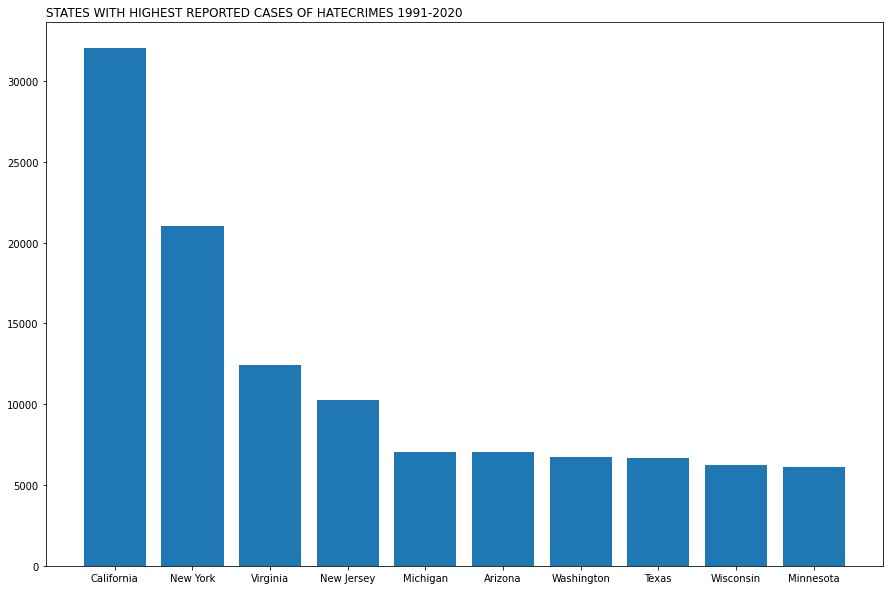

In [ ]:
temp = pd.read_sql_query('''SELECT 
                    state.name as state,
                    count(state.name) as incidents

                    from crime
                    join county on crime.county_id = county.county_id
                    join state on county.state_id = state.state_id
                    group by state.name
                    order by incidents desc
                    limit 10
                ''', conn)


f = plt.figure(figsize=(15, 10))
plt.title('STATES WITH HIGHEST REPORTED CASES OF HATECRIMES 1991-2020',loc='left')
f = plt.bar(height=temp['incidents'],x=temp['state'])

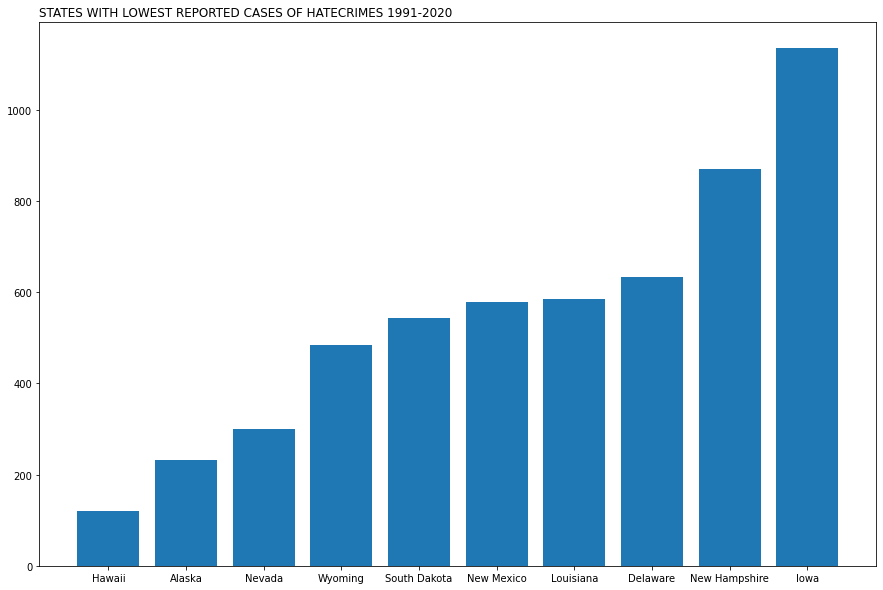

In [ ]:
temp = pd.read_sql_query('''SELECT 
                    state.name as state,
                    count(state.name) as incidents

                    from crime
                    join county on crime.county_id = county.county_id
                    join state on county.state_id = state.state_id
                    group by state.name
                    order by incidents
                    limit 10
                ''', conn)


f = plt.figure(figsize=(15, 10))
plt.title('STATES WITH LOWEST REPORTED CASES OF HATECRIMES 1991-2020',loc='left')
f = plt.bar(height=temp['incidents'],x=temp['state'])

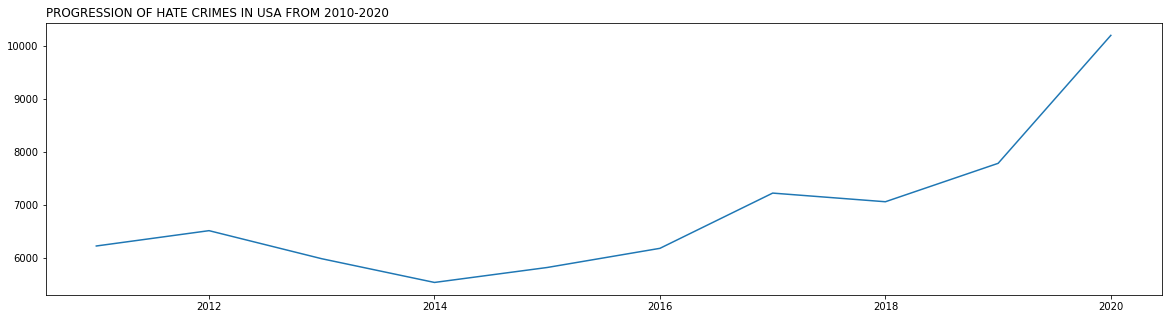

In [ ]:
temp = pd.read_sql_query('''
                    with subresult as (
                      select
                      cast(substr(crime.date,-4) as int) as Year
                      from crime
                      )

                      select year, count(year) as incidents from subresult 
                      where year>2010
                      group by Year
                      
                ''', conn)

f = plt.figure(figsize=(20, 5))
plt.title('PROGRESSION OF HATE CRIMES IN USA FROM 2010-2020',loc='left')
f = plt.plot(temp['Year'],temp['incidents'])

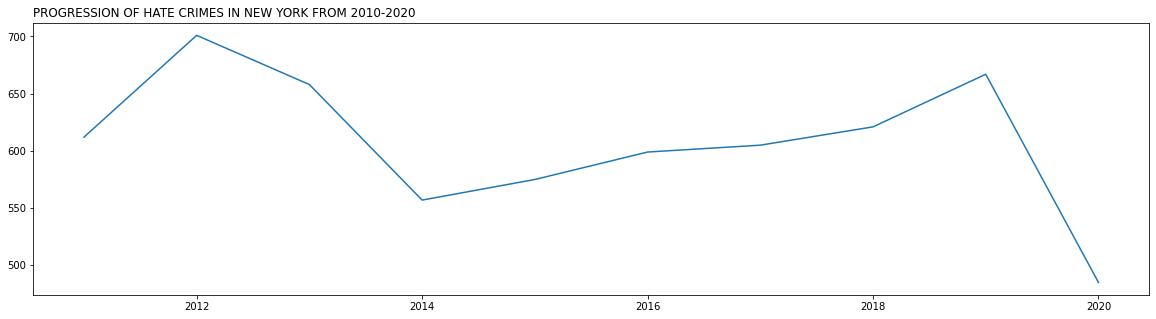

In [ ]:
temp = pd.read_sql_query('''
                      select 
                          cast(substr(crime.date,-4) as int) as Year, 
                          count(crime_id) as incidents
                          from crime

                      join county on crime.county_id=county.county_id
                      join state on county.state_id=state.state_id
                      where state.name = "New York" AND year>2010
                      group by Year
                ''', conn)

f = plt.figure(figsize=(20, 5))
plt.title('PROGRESSION OF HATE CRIMES IN NEW YORK FROM 2010-2020',loc='left')
f = plt.plot(temp['Year'],temp['incidents'])

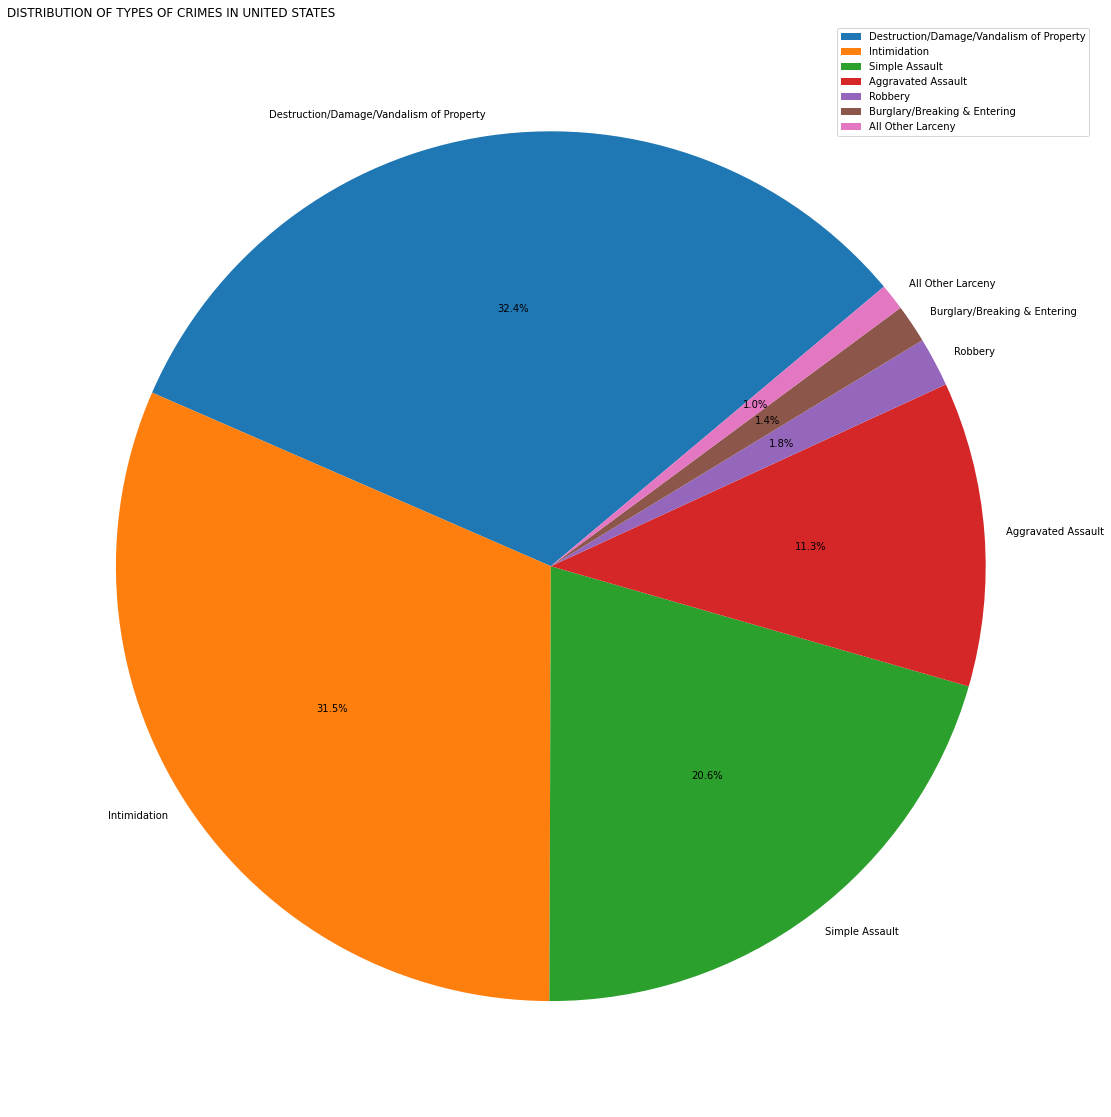

In [25]:
temp = pd.read_sql_query('''     
              select offence.Description, count(crime_id) as incidents 
                      from crime
                      
                      join offence on offence.offence_id = crime.offence_id
                      join county on crime.county_id=county.county_id
                      join state on county.state_id=state.state_id
                      
                      group by offence.offence_id
                      order by incidents desc
                      limit 7         
                ''', conn)

f = plt.figure(figsize=(20, 20))
plt.title('DISTRIBUTION OF TYPES OF CRIMES IN UNITED STATES',loc='left')
f = plt.pie(x=temp['incidents'],labels=temp['Description'],startangle=40,labeldistance=1.05, autopct='%1.1f%%')
plt.legend(loc=0)

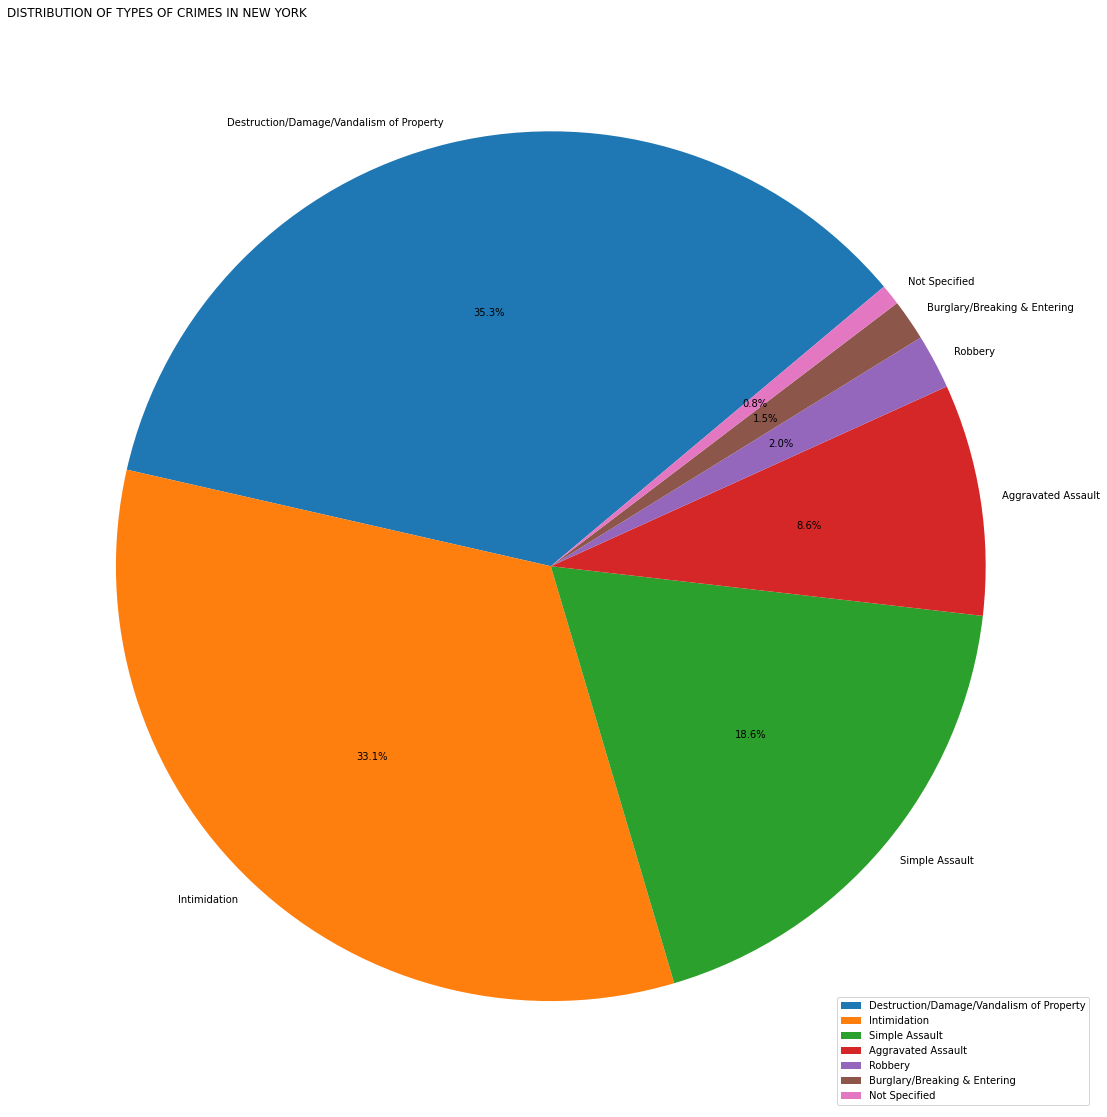

In [21]:
temp = pd.read_sql_query('''
            select offence.Description, count(crime_id) as incidents 
                    from crime
                    
                    join offence on offence.offence_id = crime.offence_id
                    join county on crime.county_id=county.county_id
                    join state on county.state_id=state.state_id

                    where state.name = "New York"
                    
                    group by offence.offence_id
                    order by incidents desc
                    limit 7
                ''', conn)

f = plt.figure(figsize=(20, 20))
plt.title('DISTRIBUTION OF TYPES OF CRIMES IN NEW YORK',loc='left')
f = plt.pie(x=temp['incidents'],labels=temp['Description'],startangle=40,labeldistance=1.05, autopct='%1.1f%%')
plt.legend(loc=0)

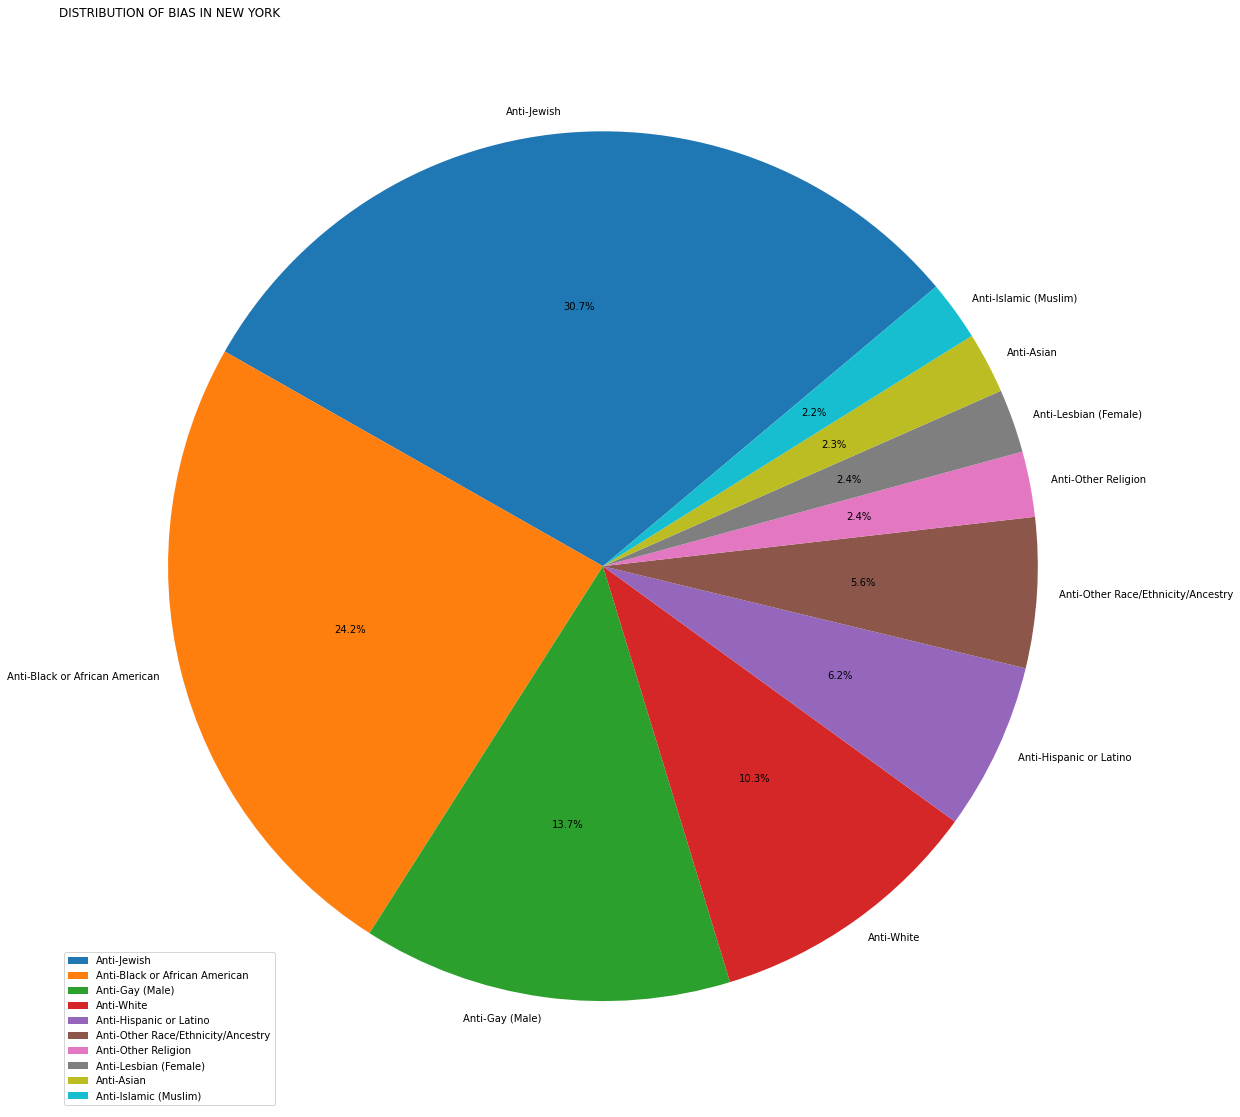

In [22]:
temp = pd.read_sql_query('''
                    select bias.Description, count(crime_id) as incidents 
                        from crime
                    
                    join bias on bias.bias_id = crime.bias_id
                    join county on crime.county_id=county.county_id
                    join state on county.state_id=state.state_id

                    where state.name = "New York"
                    
                    group by bias.bias_id
                    order by incidents desc
                    limit 10
                ''', conn)

f = plt.figure(figsize=(20, 20))
plt.title('DISTRIBUTION OF BIAS IN NEW YORK',loc='left')
f = plt.pie(x=temp['incidents'],labels=temp['Description'],startangle=40,labeldistance=1.05, autopct='%1.1f%%')
plt.legend(loc=0)

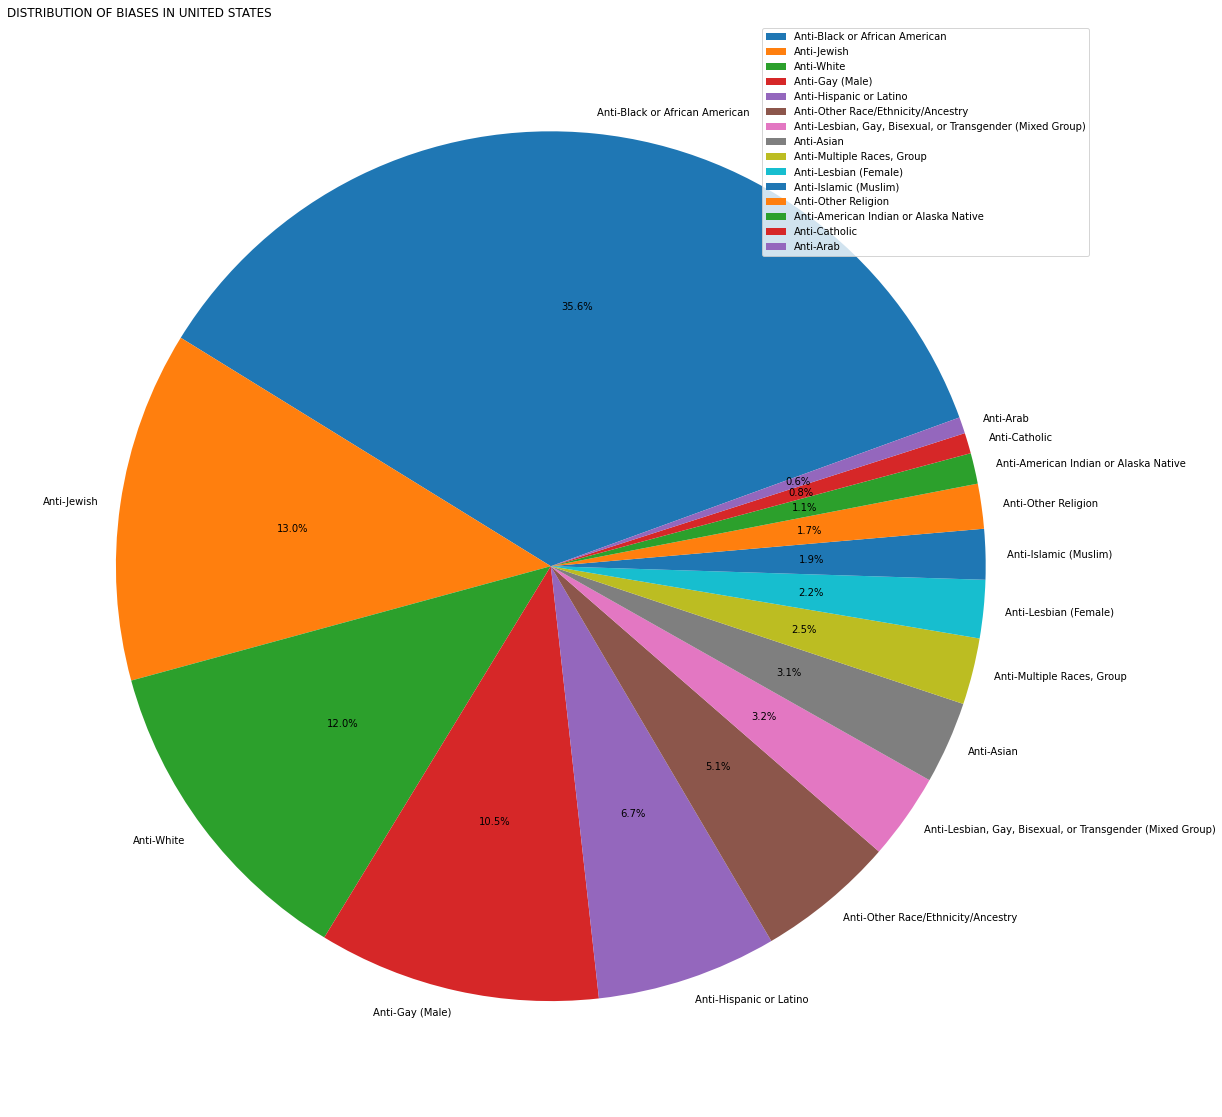

In [ ]:
temp = pd.read_sql_query('''     
                        select bias.Description, count(crime_id) as incidents 
                        from crime
                        join bias on crime.bias_id = bias.bias_id
                        group by bias.bias_id
                        order by incidents desc
                        limit 15                     
                ''', conn)

f = plt.figure(figsize=(20, 20))
plt.title('DISTRIBUTION OF BIASES IN UNITED STATES',loc='left')
f = plt.pie(x=temp['incidents'],labels=temp['Description'],startangle=20,labeldistance=1.05,autopct='%1.1f%%')
plt.legend(loc=0)